## Data import, manipulation, and joining

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

In [2]:
#initial attempt to read the takehome_users.csv failed due to an encoding issue. This will provide me with the encoding for
#this file. This is based on python solution for https://stackoverflow.com/questions/37177069/how-to-check-encoding-of-a-csv-file
with open('takehome_users.csv') as f:
    print(f)

<_io.TextIOWrapper name='takehome_users.csv' mode='r' encoding='cp1252'>


In [3]:
t_user = pd.read_csv('takehome_users.csv', encoding='cp1252')
t_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [54]:
t_user.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [4]:
#double checking encoding on this one just in case it is different than the other.
with open('takehome_user_engagement.csv') as f:
    print(f)

<_io.TextIOWrapper name='takehome_user_engagement.csv' mode='r' encoding='cp1252'>


In [5]:
t_user_eng = pd.read_csv('takehome_user_engagement.csv', encoding='cp1252')
t_user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
t_user_eng.time_stamp = pd.to_datetime(t_user_eng.time_stamp)

In [10]:
t_user_eng['date'] = t_user_eng.time_stamp.dt.date
t_user_eng.head()

,time_stamp,user_id,visited,date
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [23]:
df = t_user_eng[t_user_eng['user_id']==2]
d = df['date'].loc[1]
print(d)
df_greater = df[df['date']>=d]
df_greater.head()

2013-11-15


,time_stamp,user_id,visited,date
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25
5,2013-12-31 03:45:04,2,1,2013-12-31


In [32]:
#build a list of user_ids
user_ids = t_user_eng['user_id'].unique()
visitlog = []
#iterate through the unique ids
for id in user_ids:
    max_visits = 0
    #select the active user of interest
    df = t_user_eng[t_user_eng['user_id']==id]
    for i in range(len(df)):
        #Check there are more than 3 logins in the selection
        d = df['date'].iloc[i]
        df_greater = df[df['date']>=d]
        df_7d = df_greater[df_greater['date']<(d+timedelta(days=7))]
        if len(df_7d)>max_visits:
            max_visits = len(df_7d)
        else:
            pass
    visitlog.append((id,max_visits))
visitlog[:2]

[(1, 1), (2, 3)]

In [63]:
#convert this list of tuples to a dataframe
user_data = pd.DataFrame.from_records(visitlog, columns =['object_id', 'max_visits'])
user_data.head()

,object_id,max_visits
0,1,1
1,2,3
2,3,1
3,4,1
4,5,1


In [64]:
#create a flag for users that interacted with the software more than 3 times in a week
user_data['adopted'] = user_data.max_visits.map(lambda x: 1 if x>=3 else 0)
user_data.head()

,object_id,max_visits,adopted
0,1,1,0
1,2,3,1
2,3,1,0
3,4,1,0
4,5,1,0


In [65]:
#join this new table to the t_user dataframe
user_data.set_index('object_id',inplace=True)
t_user.set_index('object_id',inplace=True)
full_user = t_user.join(user_data, how='left',rsuffix='2')
full_user.head(2)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,max_visits,adopted
object_id,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,0.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,3.0,1.0


In [66]:
#a little bit of clean up
full_user['last_session_creation_time'] = pd.to_datetime(full_user['last_session_creation_time'],unit='s')
full_user.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,max_visits,adopted
object_id,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1.0,0.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,3.0,1.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,1.0,0.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1.0,0.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1.0,0.0


In [67]:
full_user.isna().sum()

creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
max_visits                    3177
adopted                       3177
dtype: int64

In [68]:
#ok... whats with the users without a last_session_creation_time? Are these accounts that haven't logged in ever?
full_user[full_user['last_session_creation_time'].isna()].head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,max_visits,adopted
object_id,,,,,,,,,,,
8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN,NaN,NaN
9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN,NaN,NaN
12,2014-04-17 23:48:38,Mathiesen Lærke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,NaT,0,0,130,9270.0,NaN,NaN
15,2013-07-16 21:33:54,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,175,NaN,NaN,NaN
16,2013-02-11 10:09:50,Engel René,ReneEngel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,211,NaN,NaN,NaN


These appear to be accounts that were created but never utilized. While this may be an interesting population to try to figure out why they never came back I am going to drop these rows for this analysis.

In [69]:
#dropping rows missing a last session
full_user = full_user[~full_user['last_session_creation_time'].isna()]

In [72]:
#filling invited_by_user_id with a 0 if null
full_user['invited_by_user_id'].fillna(0,inplace=True)
#map in a boolean for if there was a user that invited them
full_user['user_invited'] = full_user.invited_by_user_id.map(lambda x: 1 if x>=1 else 0)

In [145]:
#fix that creation time is a string and it should be a datetime...
full_user['creation_time'] = pd.to_datetime(full_user['creation_time'])

In [161]:
full_user.describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,max_visits,adopted,user_invited
count,8823.000000,8823.000000,8823.000000,8823.000000,8823.000000,8823.000000,8823.000000
mean,0.252295,0.151989,142.572254,3237.316786,1.866259,0.181571,0.541312
std,0.434354,0.359031,124.176422,3888.088044,1.812267,0.385512,0.498319
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,30.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,109.000000,1055.000000,1.000000,0.000000,1.000000
75%,1.000000,0.000000,239.000000,6405.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,416.000000,11999.000000,7.000000,1.000000,1.000000


## Data visualization

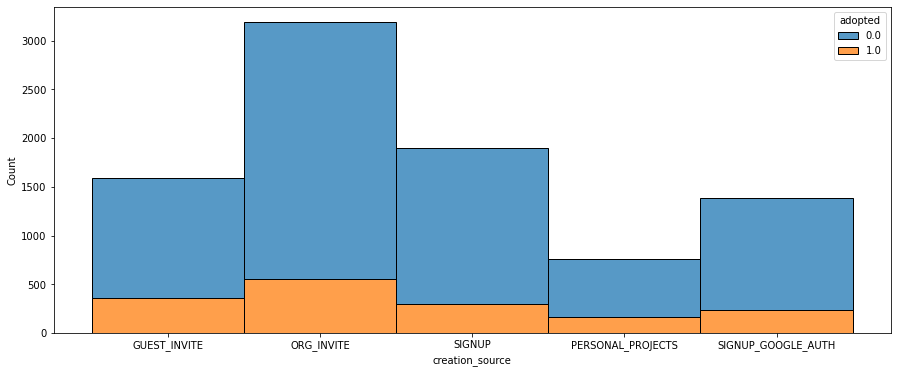

In [146]:
f, ax = plt.subplots(figsize=(15, 6))
sns.histplot(data=full_user, multiple="stack", x='creation_source', hue='adopted',bins=20)
plt.show()

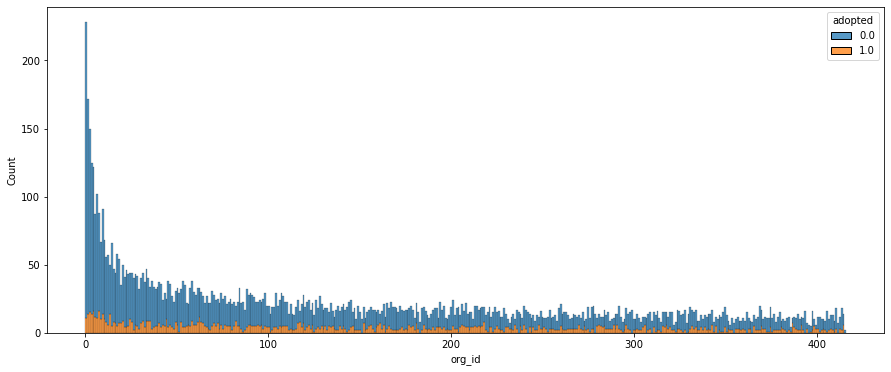

In [150]:
f, ax = plt.subplots(figsize=(15, 6))
sns.histplot(data=full_user, multiple="stack", x='org_id', hue='adopted',bins=417)
plt.show()

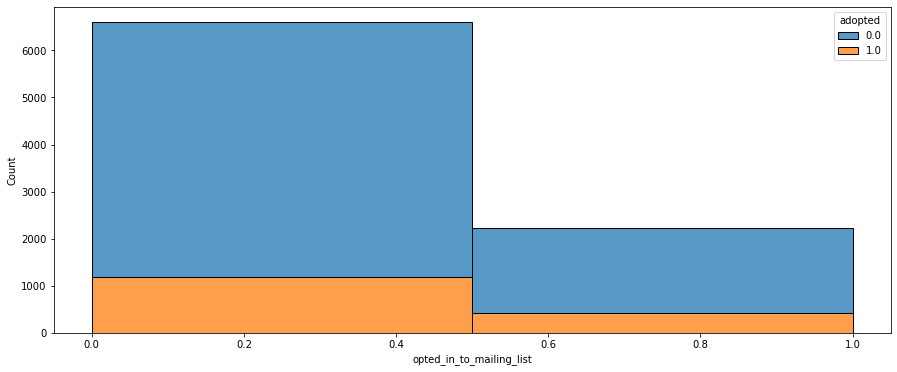

In [152]:
f, ax = plt.subplots(figsize=(15, 6))
sns.histplot(data=full_user, multiple="stack", x='opted_in_to_mailing_list', hue='adopted',bins=2)
plt.show()

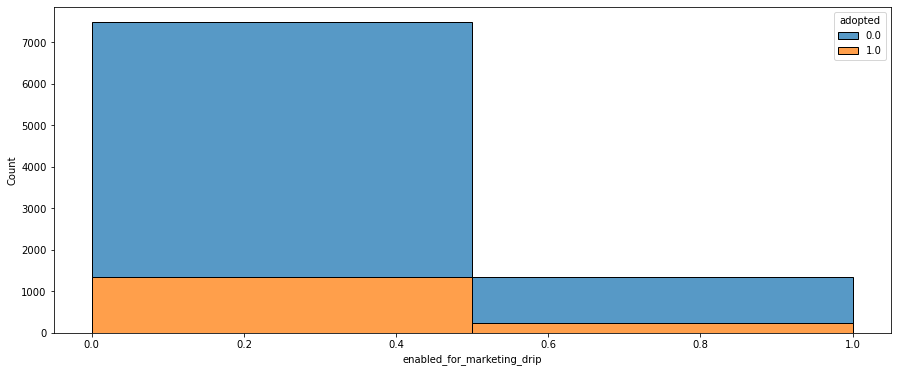

In [153]:
f, ax = plt.subplots(figsize=(15, 6))
sns.histplot(data=full_user, multiple="stack", x='enabled_for_marketing_drip', hue='adopted',bins=2)
plt.show()

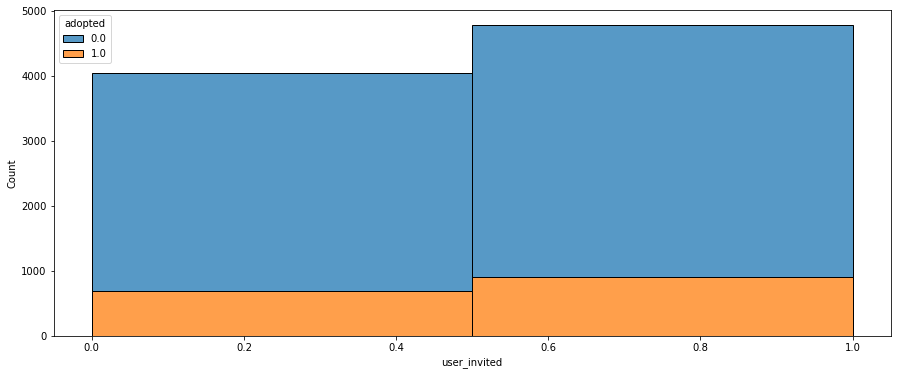

In [154]:
f, ax = plt.subplots(figsize=(15, 6))
sns.histplot(data=full_user, multiple="stack", x='user_invited', hue='adopted',bins=2)
plt.show()

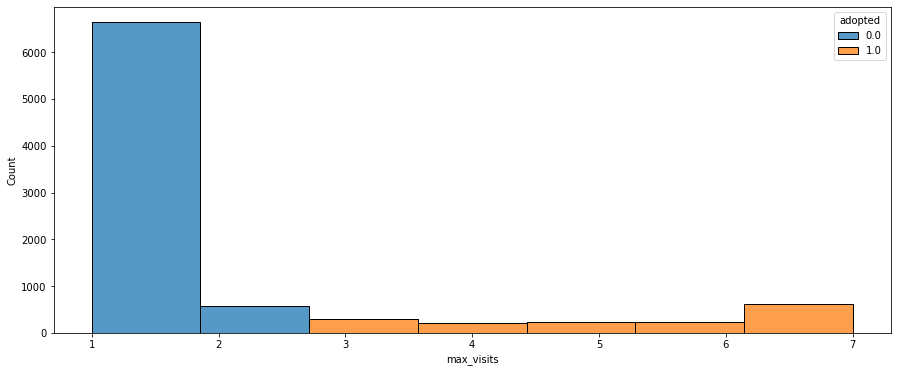

In [160]:
f, ax = plt.subplots(figsize=(15, 6))
sns.histplot(data=full_user, multiple="stack", x='max_visits', hue='adopted',bins=7)
plt.show()

## Prepare data and model

In [112]:
#prep for modeling, also going to drop unique ID information like name, email, creation time, and max_visits autocorrolates with adopted
y = full_user['adopted']
X = full_user.drop(['adopted','name','email','creation_time','last_session_creation_time','max_visits','invited_by_user_id'],axis=1)

In [113]:
X = pd.get_dummies(X,columns=['creation_source'],drop_first=True)

In [85]:
#fix that creation time is a string...
X['creation_time'] = pd.to_datetime(X['creation_time'])

In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [138]:
#create a Random Forest Classification model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rfc = RandomForestClassifier(random_state=42,class_weight='balanced_subsample')
rfc.fit(X_train, y_train)
# accuracy score based on test data
print(accuracy_score(rfc.predict(X_test), y_test))

0.6849263316962599


In [139]:
feat_imp = pd.Series(rfc.feature_importances_, index = X_train.columns).sort_values(ascending = False)
feat_imp[:10]

org_id                                0.960213
opted_in_to_mailing_list              0.010596
enabled_for_marketing_drip            0.008880
creation_source_ORG_INVITE            0.005958
creation_source_SIGNUP                0.004272
user_invited                          0.004061
creation_source_PERSONAL_PROJECTS     0.003472
creation_source_SIGNUP_GOOGLE_AUTH    0.002549
dtype: float64

In [140]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,classification_report
from sklearn import metrics
y_test_pred = rfc.predict(X_test)
print("Random Forest Model - no max depth")
print("Accuracy:", metrics.accuracy_score(y_test,y_test_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_test_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test,y_test_pred, pos_label = 1))
print('Precision score for "No"' , metrics.precision_score(y_test,y_test_pred, pos_label = 0))
print('Recall score for "Yes"' , metrics.recall_score(y_test,y_test_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test,y_test_pred, pos_label = 0))
confusion_matrix = pd.crosstab(y_test,y_test_pred, rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Random Forest Model - no max depth
Accuracy: 0.6849263316962599
Balanced accuracy: 0.5223447298261426
Precision score for "Yes" 0.21702838063439064
Precision score for "No" 0.82177734375
Recall score for "Yes" 0.26262626262626265
Recall score for "No" 0.7820631970260223
Predicted   0.0  1.0
Actual              
0.0        1683  469
1.0         365  130


This model seems to be way to dependant on the org_id. It is also doing a terible job at predicting the yes flag for adoption getting more than 3 times as many yes predictions wrong as right.

In [141]:
#attempt to tune this model to be a little better
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
rfc2 = RandomForestClassifier(random_state=42,class_weight='balanced_subsample')
params = dict(n_estimators=range(10,100),min_samples_leaf=uniform(.001,.1))
rf_cv = RandomizedSearchCV(rfc2, params, random_state=42)
rf_cv.fit(X_train, y_train)
print(accuracy_score(rf_cv.predict(X_test), y_test))
print('Best params: '+str(rf_cv.best_params_))

0.5527011711371363
Best params: {'min_samples_leaf': 0.01099749158180029, 'n_estimators': 84}


In [142]:
#That looks better lets recreate that so we can look closer at that result.
rfc2 = RandomForestClassifier(random_state=42,min_samples_leaf=0.01099749158180029,n_estimators=84,class_weight='balanced_subsample')
rfc2.fit(X_train, y_train)
print(accuracy_score(rfc2.predict(X_test), y_test))

0.5527011711371363


In [143]:
feat_imp = pd.Series(rfc2.feature_importances_, index = X_train.columns).sort_values(ascending = False)
feat_imp[:10]

org_id                                0.815281
creation_source_SIGNUP                0.043980
user_invited                          0.033660
opted_in_to_mailing_list              0.030943
creation_source_ORG_INVITE            0.026409
creation_source_PERSONAL_PROJECTS     0.020797
enabled_for_marketing_drip            0.018237
creation_source_SIGNUP_GOOGLE_AUTH    0.010694
dtype: float64

In [144]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,classification_report
from sklearn import metrics
y_test_pred = rfc2.predict(X_test)
print("Random Forest Model - no max depth")
print("Accuracy:", metrics.accuracy_score(y_test,y_test_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_test_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test,y_test_pred, pos_label = 1))
print('Precision score for "No"' , metrics.precision_score(y_test,y_test_pred, pos_label = 0))
print('Recall score for "Yes"' , metrics.recall_score(y_test,y_test_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test,y_test_pred, pos_label = 0))
confusion_matrix = pd.crosstab(y_test,y_test_pred, rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Random Forest Model - no max depth
Accuracy: 0.5527011711371363
Balanced accuracy: 0.5506890465998273
Precision score for "Yes" 0.22014622258326563
Precision score for "No" 0.8418079096045198
Recall score for "Yes" 0.5474747474747474
Recall score for "No" 0.5539033457249071
Predicted   0.0  1.0
Actual              
0.0        1192  960
1.0         224  271


In [130]:
from sklearn import svm
clf = svm.SVC(random_state=42,class_weight='balanced')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print("Random Forest Model - no max depth")
print("Accuracy:", metrics.accuracy_score(y_test,y_test_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_test_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test,y_test_pred, pos_label = 1))
print('Precision score for "No"' , metrics.precision_score(y_test,y_test_pred, pos_label = 0))
print('Recall score for "Yes"' , metrics.recall_score(y_test,y_test_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test,y_test_pred, pos_label = 0))
confusion_matrix = pd.crosstab(y_test,y_test_pred, rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Random Forest Model - no max depth
Accuracy: 0.4635436343029845
Balanced accuracy: 0.5557437760504675
Precision score for "Yes" 0.2146822948797039
Precision score for "No" 0.8567251461988304
Recall score for "Yes" 0.703030303030303
Recall score for "No" 0.40845724907063197
Predicted  0.0   1.0
Actual              
0.0        879  1273
1.0        147   348


The support vector machine performs even worse.

In [159]:
#This model is just for curiousity... what happens if I drop org_id
X_train_red = X_train.drop('org_id',axis=1)
X_test_red = X_test.drop('org_id',axis=1)
rfc3 = RandomForestClassifier(random_state=42,class_weight='balanced_subsample')
rfc3.fit(X_train_red, y_train)
# accuracy score based on test data
print(accuracy_score(rfc3.predict(X_test_red), y_test))
y_test_pred = rfc3.predict(X_test_red)
print("Random Forest Model - no max depth")
print("Accuracy:", metrics.accuracy_score(y_test,y_test_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_test_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test,y_test_pred, pos_label = 1))
print('Precision score for "No"' , metrics.precision_score(y_test,y_test_pred, pos_label = 0))
print('Recall score for "Yes"' , metrics.recall_score(y_test,y_test_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test,y_test_pred, pos_label = 0))
confusion_matrix = pd.crosstab(y_test,y_test_pred, rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)
feat_imp = pd.Series(rfc3.feature_importances_, index = X_train_red.columns).sort_values(ascending = False)
print(feat_imp[:10])

0.6169248205515678
Random Forest Model - no max depth
Accuracy: 0.6169248205515678
Balanced accuracy: 0.5411883706958056
Precision score for "Yes" 0.22245989304812835
Precision score for "No" 0.8323598130841121
Recall score for "Yes" 0.4202020202020202
Recall score for "No" 0.6621747211895911
Predicted   0.0  1.0
Actual              
0.0        1425  727
1.0         287  208
enabled_for_marketing_drip            0.205612
opted_in_to_mailing_list              0.180076
creation_source_SIGNUP                0.175843
creation_source_ORG_INVITE            0.137087
user_invited                          0.132102
creation_source_PERSONAL_PROJECTS     0.090751
creation_source_SIGNUP_GOOGLE_AUTH    0.078529
dtype: float64


In [166]:
#Just becasue I am curious, what happens to the count of active useres if instead of 3 visits in 1 week we look for 3 visits in 2 weeks.
user_ids = t_user_eng['user_id'].unique()
visitlog14 = []
#iterate through the unique ids
for id in user_ids:
    max_visits = 0
    #select the active user of interest
    df = t_user_eng[t_user_eng['user_id']==id]
    for i in range(len(df)):
        #Check there are more than 3 logins in the selection this time I'm going to use 14 day window
        d = df['date'].iloc[i]
        df_greater = df[df['date']>=d]
        df_14d = df_greater[df_greater['date']<(d+timedelta(days=14))]
        if len(df_14d)>max_visits:
            max_visits = len(df_14d)
        else:
            pass
    visitlog14.append((id,max_visits))
#convert this list of tuples to a dataframe
user_data14 = pd.DataFrame.from_records(visitlog14, columns =['object_id', 'max_visits14'])
user_data14['adopted'] = user_data14.max_visits14.map(lambda x: 1 if x>=3 else 0)
user_data14.head()

,object_id,max_visits14,adopted
0,1,1,0
1,2,5,1
2,3,1,0
3,4,1,0
4,5,1,0


In [167]:
user_data14['adopted'].value_counts()

0    6930
1    1893
Name: adopted, dtype: int64

I've attempted several different models with the provided data. None of them were satisfactory to me. The fact that org_id has been the most predictive feature for adoption is a problem since this should more likely be treated as a catigorical column. Despite this, looking at the histograms there is visually a tendency for the lower numbered organizations to have higher adoption. Apart from org_id, enabled_for_marketing_drip, opted_in_to_mailing_list, and creation_source_SIGNUP seem to be the most common and powerful predictors in the (admitedly poor performing) models. 

All of the attempted models struggled with how unbalanced the target feature was. Users who were classified as adopted made up only 4% of the initial population, and 5.6% of the population once the records without a last session creation time. This low adoption rate is partly due to how restrictive 3 unique days logins in a single week. Were the metric for adoption to be expanded to even a 14 day period there would be 21.5% of the users classified as adopted users. 

This problem seems like additional research would be needed improve the ability to predict user adoption. First, I would investigate more into the organizations and why this seemingly categorical feature seems to be predictive. Are there additional information about these groups that could provide additional worthwhile features? I would then recommend looking in to how user adoption was defined. As mentioned above the hurdle for a user classified as adopted seems quite high and further investigation on this classifier may be merited. Finally I would look to see if there were avenues to collect additional data in the registration process to better classify new users. This would provide additional data which could be useful for more successful modeling.